# Intro

The following code provides you with surprisal values for the same data you used in Homework 2.  The surprisal values are based on the output of an RNN model.

We leave it up to you to perform the alignment between the model output and the reading times!

Feel free to skim through the code, it might be helpful for the semi-structured and open-ended tasks!

## Set up dependencies and data

Run the cell below to fetch the recurrent neural network codebase we've designed for this assignment.

It will leave the files in a directory called `rnn` (check in the sidebar after you've run the command).

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.3 MB/s eta 0:00:00


In [ ]:
pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 80.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 

In [ ]:
import pandas as pd
from google.colab import drive
import statsmodels.api as sm
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
from collections import defaultdict
from statsmodels.gam.api import GLMGam, BSplines, CyclicCubicSplines
from statsmodels.tools.eval_measures import mse
import torch
from transformers import AutoTokenizer, GPT2LMHeadModel
from scipy.special import softmax
from flair.data import Sentence
from flair.splitter import SegtokSentenceSplitter
from flair.nn import Classifier
from flair.models import SequenceTagger

In [ ]:
%%bash
git clone https://github.com/scaperex/neural-complexity.git rnn
git clone https://github.com/languageMIT/naturalstories naturalstories
mkdir -p rnn/data/ptb

Cloning into 'rnn'...
Cloning into 'naturalstories'...
Updating files: 100% (62/62), done.


## Mount Google Drive

We'll save your corpus data, model checkpoints, and output to Google Drive for safekeeping.

Follow the instructions in the output of this command to link your Drive account.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
GDRIVE_DIR = "/content/gdrive/My Drive/096222_project_surprisals_and_rts"
!mkdir -p "$GDRIVE_DIR"
!mkdir -p "$GDRIVE_DIR/corpus_data"


## Upload corpus files for LM training

Here we upload the Penn Treebank corpus files  to the `rnn/data/ptb` folder.
Your files should be named:

- `ptb_tok_train.txt`
- `ptb_tok_dev.txt`

In [ ]:
!wget -qO rnn/data/ptb/ptb_tok_train.txt https://gist.githubusercontent.com/scaperex/cdd4231472d6188f03ab21e2b2729fee/raw/e1b4c764561fd038470830534baaa220b0eb4c6d/ptb_tok_train.txt
!wget -qO rnn/data/ptb/ptb_tok_dev.txt https://gist.githubusercontent.com/scaperex/31eff71b74dfb8cfe93d1a9acf8ab523/raw/094d3094b06beb92cd7fd0496710cf43273f8c64/ptb_tok_dev.txt
!cp rnn/data/ptb/* "$GDRIVE_DIR/corpus_data/"

# Recurrent neural network modeling

## Train model

Now we're ready to begin training the model. The below command will launch the neural network optimization procedure, and progressively save checkpoints to the Google Drive you've just mounted. The neural network train for 40 epochs (1 epoch = 1 loop through the training dataset), which should take approximately **2 hours**.

Checkpoints will be saved each time the validation loss improves, and named `ptb_model.pt`. Watch the output of the command below to see how the model's train and validation perplexity improve over time.

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train.txt --validfname ptb_tok_dev.txt

## Compute surprisals

Now we'll compute model surprisals for the text data in `brown.txt` (already downloaded for you). This will output a file called `rnn_surprisals.tsv` to your Google Drive, which you'll use in the next steps of the analysis.

We'll load the checkpoint and use it to extract per-token surprisal estimates.

In [ ]:
checkpoint_to_use = f"{GDRIVE_DIR}/ptb_model.pt"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir './data' \
    --testfname 'brown.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


Cool, let's check that the surprisal output looks right. (Compare with the ngram model surprisals from before.)

In [ ]:
rnn_surprisals = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals.tsv',sep=' ')
rnn_surprisals

,word,sentid,sentpos,wlen,surp,entropy,entred
0,In,0,0,2,5.506053,9.515585,0.000000
1,<unk>,0,1,5,6.578504,7.866125,1.649460
2,County,0,2,6,12.514248,6.056062,1.810063
3,<unk>,0,3,5,7.031470,8.524199,0.000000
4,near,0,4,4,13.308077,8.640187,0.000000
...,...,...,...,...,...,...,...
7229,as,363,15,2,6.248776,4.505761,3.256542
7230,a,363,16,1,2.861911,7.777086,0.000000
7231,leader,363,17,6,11.365563,11.206182,0.000000
7232,and,363,18,3,6.632089,5.544580,5.661602


## Harmonize RNN surprisal and RT data

Load and align the reading times with the n-gram model surprisals.
You may load the harmonized csv from Homework 2, or align it again.

Finallyy, align the RNN model-derived surprisal values with human reading times. The harmonize function you wrote in Homework 2 may be helpful here too.

Note, modifications may be required as the tokenization is not necessarily the same as the n-gram model.

In [ ]:
rnn_surprisals_harmonized = rnn_surprisals[(rnn_surprisals['word'] != '</s>') & (rnn_surprisals['word'] != '--') & (rnn_surprisals['word'] != '<unk>')].drop(4504).reset_index()
n_gram = pd.read_csv('/content/gdrive/MyDrive/harmonized_ngram.csv')
harmonized = n_gram.merge(rnn_surprisals_harmonized, indicator='_rnn', right_index=True, left_index=True).rename(columns={'surp': 'surprisal_rnn'})

In [ ]:
harmonized.to_csv("/content/gdrive/MyDrive/096222_project_surprisals_and_rts/harmonized.csv")

AttributeError: ignored

In [ ]:
harmonized = pd.read_csv("/content/gdrive/MyDrive/096222_project_surprisals_and_rts/harmonized.csv")

# Analysis

In [ ]:
print('n-gram surprisal correlation with reading time:', harmonized['surprisal'].corr(harmonized['mean_time']))
print('rnn surprisal correlation with reading time:', harmonized['surprisal_rnn'].corr(harmonized['mean_time']))

n-gram surprisal correlation with reading time: 0.1999672819161163
rnn surprisal correlation with reading time: 0.20209394543277748


In [ ]:
print(harmonized['surprisal'].corr(harmonized['surprisal_rnn']))

0.8949638467338369


Both models produce a similar correlation with the reading time.

In [ ]:


y = harmonized['mean_time']
x = harmonized['surprisal']
x = sm.add_constant(x)

lin_model= sm.OLS(y, x).fit()

print(lin_model.summary())
print('MSE:', mse(lin_model.predict(x), y))

                            OLS Regression Results                            
Dep. Variable:              mean_time   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     229.0
Date:                Tue, 30 May 2023   Prob (F-statistic):           1.02e-50
Time:                        18:25:22   Log-Likelihood:                -27813.
No. Observations:                5500   AIC:                         5.563e+04
Df Residuals:                    5498   BIC:                         5.564e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        283.7463      1.172    242.125      0.0

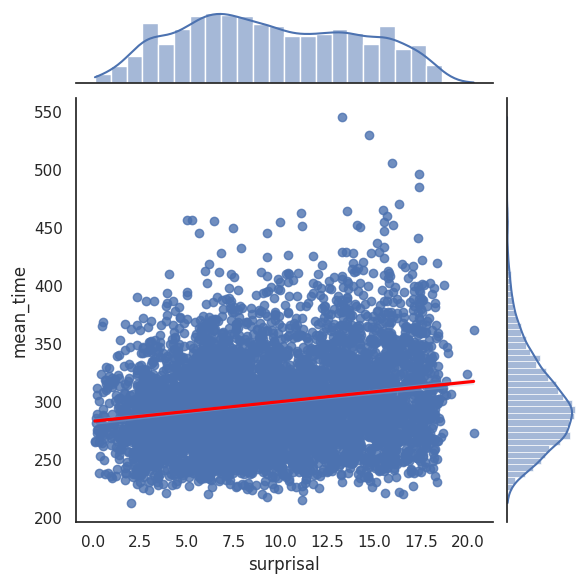

In [ ]:


g = sns.jointplot(x="surprisal", y="mean_time", data=harmonized, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

In [ ]:
y = harmonized['mean_time']
x = harmonized['surprisal_rnn']
x = sm.add_constant(x)

lin_model= sm.OLS(y, x).fit()

print(lin_model.summary())
print('MSE:', mse(lin_model.predict(x), y))

                            OLS Regression Results                            
Dep. Variable:              mean_time   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     234.1
Date:                Tue, 30 May 2023   Prob (F-statistic):           8.72e-52
Time:                        18:25:54   Log-Likelihood:                -27810.
No. Observations:                5500   AIC:                         5.562e+04
Df Residuals:                    5498   BIC:                         5.564e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           284.3492      1.126    252.487

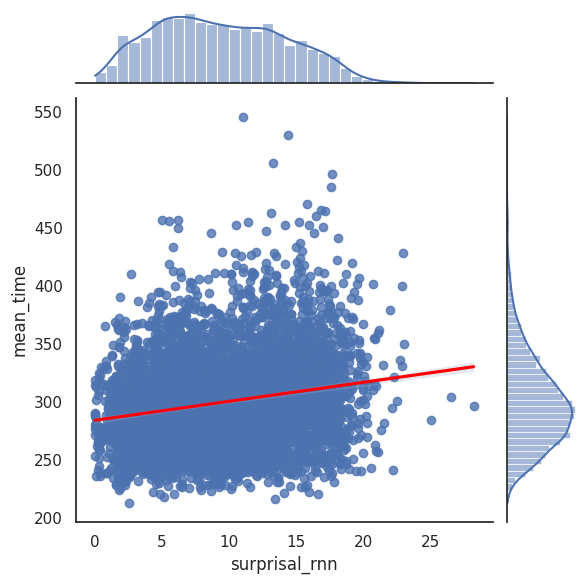

In [ ]:


g = sns.jointplot(x="surprisal_rnn", y="mean_time", data=harmonized, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

Both models produce nearly identical linear regression models, the RNN model seems to assign higher surprisal values, as the max surprisal value of the n-gram model is about 20.

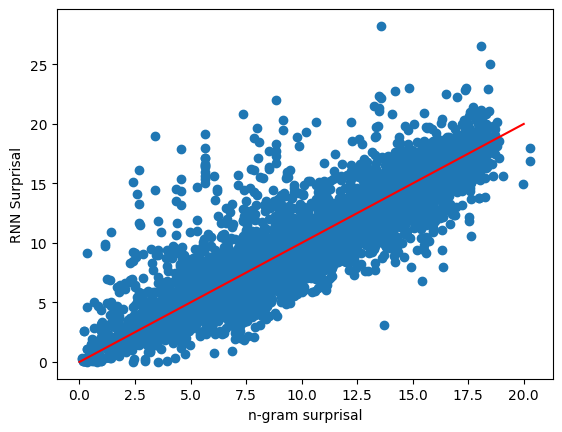

In [ ]:
plt.scatter(harmonized['surprisal'], harmonized['surprisal_rnn'])
plt.plot(range(21), range(21),color='red')
plt.ylabel('RNN Surprisal')
plt.xlabel('n-gram surprisal')
plt.show()

Overall we see that the models generally agree with each other. For most major disagreements it seems that the n-gram surprisal is smaller than the RNN surprisal.

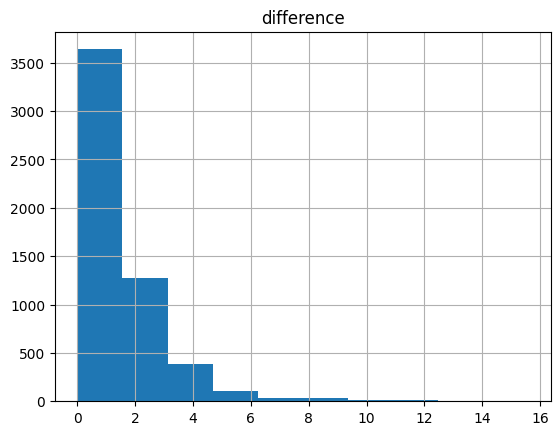

In [ ]:
harmonized['difference'] = np.abs(harmonized['surprisal'] - harmonized['surprisal_rnn'])
harmonized.hist('difference')
plt.show()

In [ ]:
harmonized.sort_values(by='difference')[['token', 'surprisal', 'surprisal_rnn', 'mean_time']].iloc[-10:]

,token,surprisal,surprisal_rnn,mean_time
4268,west,8.00778,19.646719,327.038125
1681,He,5.63280,17.962000,294.266818
1409,frequency,2.42276,15.100250,309.091111
1095,She,8.86122,22.015818,379.182500
4771,But,4.58894,17.918270,313.421000
1463,The,2.68215,16.147221,264.095789
4009,the,7.34181,20.873268,263.411250
3041,He,5.63280,19.173037,288.341905
1111,John,13.59450,28.235905,296.856316
3676,I,3.39681,18.993147,303.673750


In [ ]:
harmonized[['token', 'surprisal', 'surprisal_rnn', 'mean_time']].iloc[3676-10 : 3676+10]

,token,surprisal,surprisal_rnn,mean_time
3666,Robert,12.95350,13.060007,388.392500
3667,S.,7.73369,8.242017,297.414000
3668,a,7.86141,9.575953,329.982500
3669,native,15.71720,13.256775,295.056875
3670,New,11.58590,10.159012,272.195000
3671,had,10.85210,14.641088,308.183125
3672,been,3.18334,4.898476,279.143125
3673,a,5.03196,4.483291,267.392667
3674,World,15.64550,14.370302,301.058750
3675,War,2.49100,9.171497,290.367500


The sentence with the largest disagreement is the following:

Robert S. Fogg, a native New Englander had been a World War I barnstormer,and one of the original planners of the Concord Airport.

In general, the RNN can take into account the entire sentence up to the word in question (RNNs can actually take into account the rest of the sentence as well, but our model isn't bidirectional) while the n-gram model is more limited in scope. In this specific case, it seems the extended scope of the RNN harms it, since "I" after "World War" should have low surprisal. The more context we consider the less that context appears in our dataset, so it could be that our model requires a larger training dataset to reach its full potential.

In [ ]:
harmonized['probability'] = np.power(2, -harmonized['surprisal'])
harmonized['probability_rnn'] = np.power(2, -harmonized['surprisal_rnn'])
spillover = harmonized.iloc[:-1].reset_index()
harmonized['spillover'] = harmonized['mean_time'].iloc[1:].reset_index(drop=True)

In [ ]:
harmonized['spillover']

0       296.042941
1       348.327500
2       306.075882
3       289.048235
4       346.305294
           ...    
5495    284.470833
5496    282.622083
5497    279.445417
5498    299.705000
5499           NaN
Name: spillover, Length: 5500, dtype: float64

In [ ]:
y = harmonized.iloc[:-1]['spillover']
x = harmonized.iloc[:-1]['surprisal']
x = sm.add_constant(x)

lin_model= sm.OLS(y, x).fit()

print(lin_model.summary())
print('MSE:', mse(lin_model.predict(x), y))

                            OLS Regression Results                            
Dep. Variable:              spillover   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     97.70
Date:                Sat, 03 Jun 2023   Prob (F-statistic):           7.53e-23
Time:                        17:01:35   Log-Likelihood:                -27871.
No. Observations:                5499   AIC:                         5.575e+04
Df Residuals:                    5497   BIC:                         5.576e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        289.1459      1.186    243.875      0.0

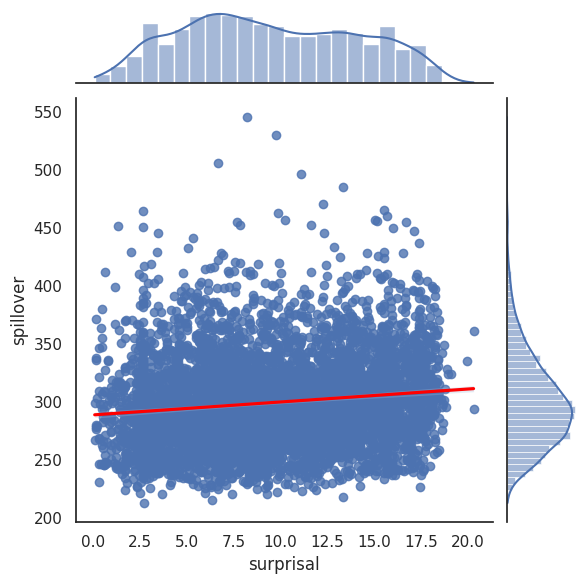

In [ ]:
g = sns.jointplot(x="surprisal", y="spillover", data=harmonized, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

In [ ]:
y = harmonized.iloc[:-1]['spillover']
x = harmonized.iloc[:-1]['surprisal_rnn']
x = sm.add_constant(x)

lin_model= sm.OLS(y, x).fit()

print(lin_model.summary())
print('MSE:', mse(lin_model.predict(x), y))

                            OLS Regression Results                            
Dep. Variable:              spillover   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     108.9
Date:                Sat, 03 Jun 2023   Prob (F-statistic):           2.87e-25
Time:                        17:02:02   Log-Likelihood:                -27865.
No. Observations:                5499   AIC:                         5.573e+04
Df Residuals:                    5497   BIC:                         5.575e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           289.1006      1.139    253.883

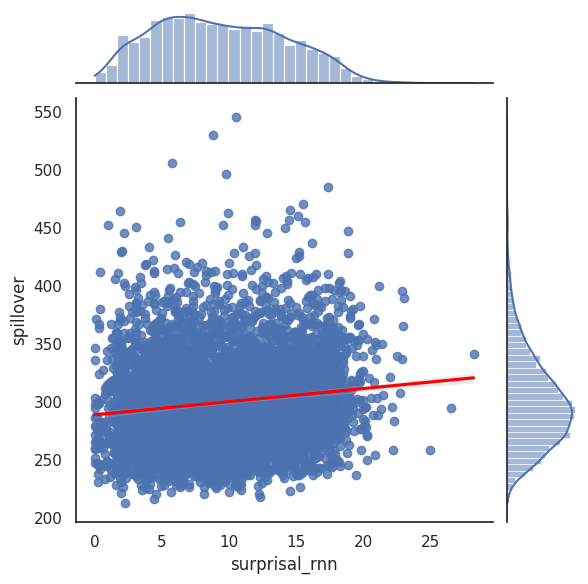

In [ ]:
g = sns.jointplot(x="surprisal_rnn", y="spillover", data=harmonized, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

# Using GAM with Word Length & Log Word Frequency

In [ ]:
harmonized['len'] = harmonized['token'].str.len()

In [ ]:
word_freq = '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/corpus_data/ptb_tok_train.txt'
with open(word_freq, 'r', encoding='utf8') as file:
  s = file.read().split(' ')
  log_freq = defaultdict(lambda: 0)
  for word in s:
    log_freq[word] += 1
  for word in log_freq:
    log_freq[word] = np.log2(log_freq[word])

In [ ]:
harmonized['log_freq'] = harmonized['token'].map(log_freq)

In [ ]:
def plot_gam_model(x, y, xlabel, ylabel='Reading Time'):
  x = sm.add_constant(x)
  bs = BSplines(x, df=[4, 4, 4, 4], degree=[3, 3, 3, 3])
  gam_model = GLMGam(y, x, smoother=bs).fit()
  print(gam_model.summary())
  print('MSE:', mse(y, gam_model.predict(x,x)))
  plt.plot(x.iloc[:, 1].sort_values(), gam_model.predict(x,x))
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
  gam_model.plot_partial(1)
  plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:              mean_time   No. Observations:                 5500
Model:                         GLMGam   Df Residuals:                     5490
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          1394.6
Method:                         PIRLS   Log-Likelihood:                -27710.
Date:                Tue, 30 May 2023   Deviance:                   7.6565e+06
Time:                        18:24:13   Pearson chi2:                 7.66e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.07784
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              262.4429      5.780  

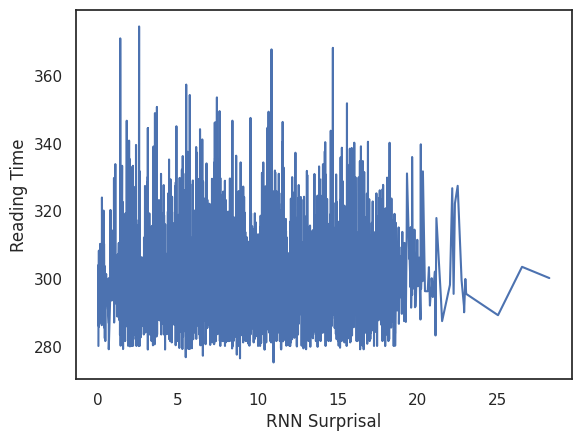

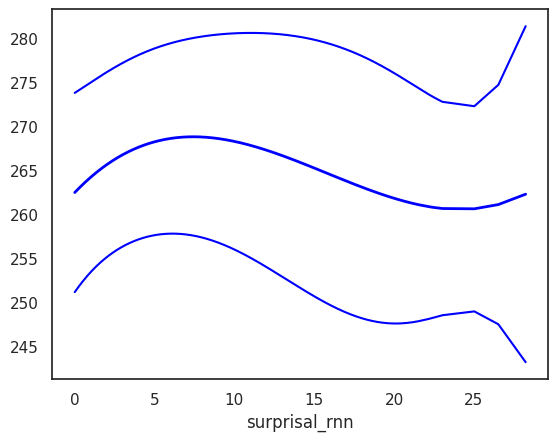

In [ ]:

plot_gam_model(harmonized[['surprisal_rnn', 'log_freq', 'len']], harmonized['mean_time'], 'RNN Surprisal')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              mean_time   No. Observations:                 5500
Model:                         GLMGam   Df Residuals:                     5490
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          1401.5
Method:                         PIRLS   Log-Likelihood:                -27724.
Date:                Tue, 30 May 2023   Deviance:                   7.6942e+06
Time:                        18:24:19   Pearson chi2:                 7.69e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.07296
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          274.7139      6.715     40.908   

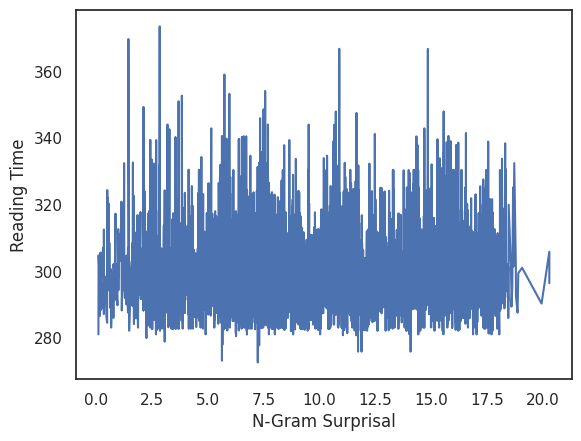

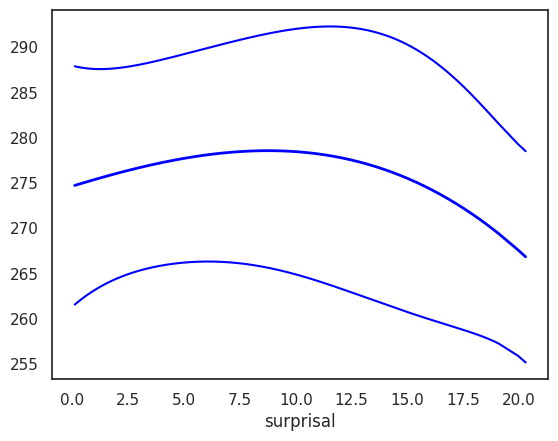

In [ ]:
plot_gam_model(harmonized[['surprisal', 'log_freq', 'len']], harmonized['mean_time'], 'N-Gram Surprisal')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              spillover   No. Observations:                 5499
Model:                         GLMGam   Df Residuals:                     5489
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          1458.9
Method:                         PIRLS   Log-Likelihood:                -27829.
Date:                Tue, 30 May 2023   Deviance:                   8.0077e+06
Time:                        18:24:22   Pearson chi2:                 8.01e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03284
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              280.4359      5.912  

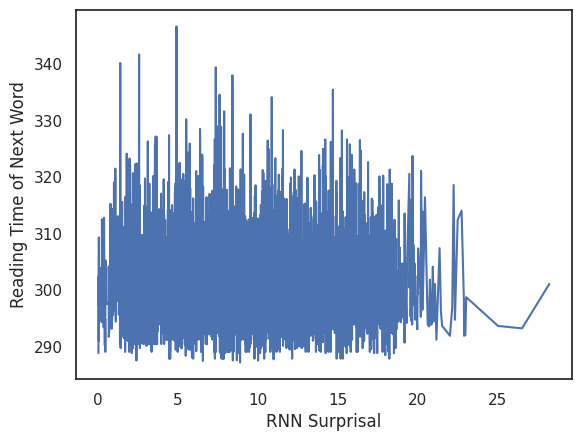

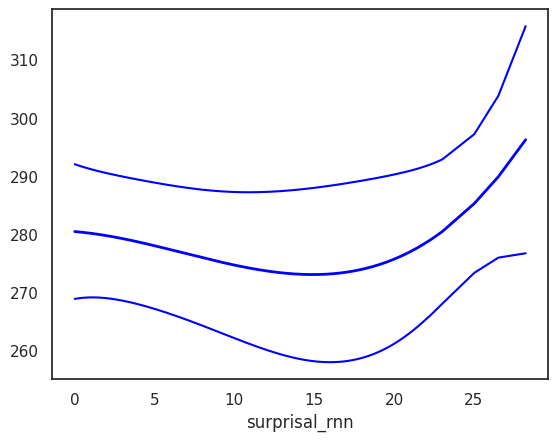

In [ ]:
plot_gam_model(harmonized.iloc[:-1, :][['surprisal_rnn', 'log_freq', 'len']], harmonized.iloc[:-1, :]['spillover'], 'RNN Surprisal', 'Reading Time of Next Word')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              spillover   No. Observations:                 5499
Model:                         GLMGam   Df Residuals:                     5489
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          1463.3
Method:                         PIRLS   Log-Likelihood:                -27837.
Date:                Tue, 30 May 2023   Deviance:                   8.0319e+06
Time:                        18:24:26   Pearson chi2:                 8.03e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.02983
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          279.5786      6.862     40.742   

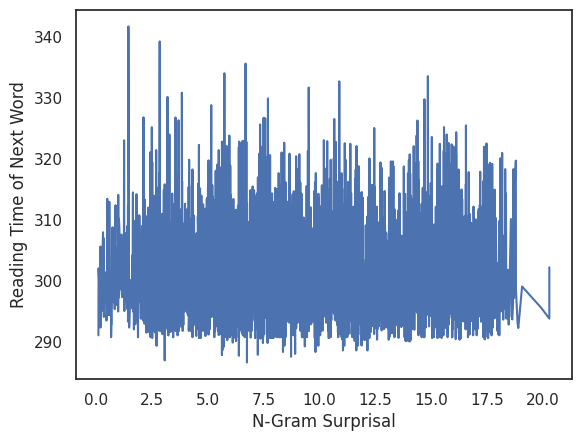

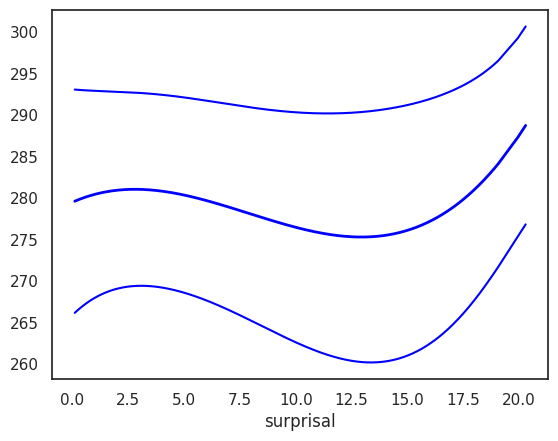

In [ ]:
plot_gam_model(harmonized.iloc[:-1, :][['surprisal', 'log_freq', 'len']], harmonized.iloc[:-1, :]['spillover'], 'N-Gram Surprisal', 'Reading Time of Next Word')

For all GAM models we get an interesting effect when looking at the connection between reading times and surprisal. The reading time increases as surprisal increases as expected but at a certain surprisal value the reading time actually decreases. This could be indicative of a more complex relationship between surprisal and reading times but it's more likely that this is a quirk of our models and data set. For spillover we see the spillover decrease as surprisal increases up to a certain point and then the spillover increases. Overall the GAM seems to model our data slightly better, with lower MSE than the linear case, but we have to remember that we used word frequency and length as well in this model and also the GAM is more complex than the linear model so it could be the decrease in MSE is a result of overfitting rather than modeling the relation better.

# Trying a Different Reading Times Corpus

In [ ]:
%%bash
git clone https://github.com/languageMIT/naturalstories naturalstories


fatal: destination path 'naturalstories' already exists and is not an empty directory.


In [ ]:
!mkdir -p "$GDRIVE_DIR/stories"

In [ ]:
stories = pd.read_csv('/content/naturalstories/naturalstories_RTS/all_stories.tok', sep='\t', header=None)
stories = stories[~(stories[0].str.contains('whole')) & ~(stories[0].str.contains('word'))]
with open('rnn/data/stories.txt', 'w', encoding='utf8') as file: file.write(' '.join(stories[0]))

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab.txt" --data_dir '/content/gdrive/MyDrive/096222_project_surprisals_and_rts/stories' \
    --testfname 'stories.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_stories_surprisals.tsv"

Libraries loaded
Using beamsize: 23757


In [ ]:
stories_surp = pd.read_csv(f"{GDRIVE_DIR}/rnn_stories_surprisals.tsv", sep=' ')
word_info = pd.read_csv('naturalstories/naturalstories_RTS/all_stories.tok', sep='\t')

In [ ]:
count = 0
to_drop = []
for index, row in word_info.iterrows():
  if row['word'] != stories_surp.iloc[index-count]['word'] and stories_surp.iloc[index-count]['word'] != '<unk>':
    count += 1
    to_drop.append(index)
word_info = word_info.drop(to_drop).reset_index()

In [ ]:
stories_surp['zone'] = word_info['zone']
stories_surp['item'] = word_info['item']
stories_surp

,word,sentid,sentpos,wlen,surp,entropy,entred,zone,item
0,If,0,0,2,6.633799,9.515585,0.000000,1,1
1,you,0,1,3,6.123430,6.663960,2.851624,2,1
2,were,0,2,4,4.394970,7.132514,0.000000,3,1
3,to,0,3,2,5.547862,9.795667,0.000000,4,1
4,journey,0,4,7,21.106024,8.359248,1.436419,5,1
...,...,...,...,...,...,...,...,...,...
10241,and,405,11,3,2.974109,3.699198,5.841850,935,10
10242,better,405,12,6,12.725901,11.445158,0.000000,936,10
10243,treatments,405,13,10,14.957111,8.406811,3.038347,937,10
10244,for,405,14,3,5.513323,2.844426,5.562385,938,10


In [ ]:
stories_rt = pd.read_csv('/content/naturalstories/naturalstories_RTS/processed_RTs.tsv', sep='\t')

In [ ]:
harmonized_stories = stories_surp.merge(stories_rt.groupby(['item', 'zone']).first().reset_index()[['item', 'zone', 'meanItemRT']], how='left', on=['zone', 'item'])
harmonized_stories = harmonized_stories[harmonized_stories['word'] != '<unk>']
harmonized_stories['spillover'] = harmonized_stories.iloc[1:].reset_index()['meanItemRT']
harmonized_stories.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/stories/harmonized_stories.csv')

In [ ]:
harmonized_stories = pd.read_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/stories/harmonized_stories.csv')

In [ ]:
harmonized_stories

,Unnamed: 0,word,sentid,sentpos,wlen,surp,entropy,entred,zone,item,meanItemRT,spillover
0,0,If,0,0,2,6.633799,9.515585,0.000000,1,1,369.011905,368.183908
1,1,you,0,1,3,6.123430,6.663960,2.851624,2,1,368.183908,344.318182
2,2,were,0,2,4,4.394970,7.132514,0.000000,3,1,344.318182,354.639535
3,3,to,0,3,2,5.547862,9.795667,0.000000,4,1,354.639535,349.674157
4,4,journey,0,4,7,21.106024,8.359248,1.436419,5,1,349.674157,376.370787
...,...,...,...,...,...,...,...,...,...,...,...,...
8273,10240,tools,405,10,5,10.980068,9.541047,0.000000,934,10,323.585714,317.414286
8274,10241,and,405,11,3,2.974109,3.699198,5.841850,935,10,317.414286,335.267606
8275,10242,better,405,12,6,12.725901,11.445158,0.000000,936,10,335.267606,359.861111
8276,10243,treatments,405,13,10,14.957111,8.406811,3.038347,937,10,359.861111,506.728571


In [ ]:
print(f"rnn corr: {harmonized_stories['surp'].corr(harmonized_stories['meanItemRT'])}")

rnn corr: 0.18240616457218806


In [ ]:
y = harmonized_stories['meanItemRT']
x = harmonized_stories['surp']
x = sm.add_constant(x)

lin_model= sm.OLS(y, x).fit()

print(lin_model.summary())
print('MSE:', mse(lin_model.predict(x), y))

                            OLS Regression Results                            
Dep. Variable:             meanItemRT   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     284.8
Date:                Sat, 03 Jun 2023   Prob (F-statistic):           7.41e-63
Time:                        15:52:17   Log-Likelihood:                -40901.
No. Observations:                8278   AIC:                         8.181e+04
Df Residuals:                    8276   BIC:                         8.182e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        319.1782      0.814    391.937      0.0

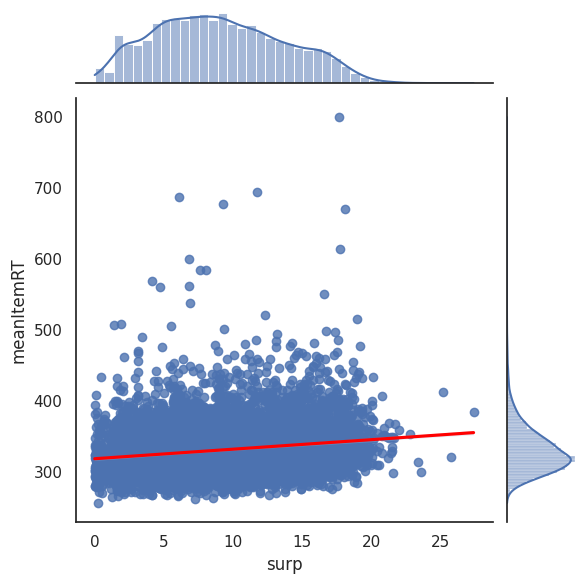

In [ ]:
g = sns.jointplot(x="surp", y="meanItemRT", data=harmonized_stories, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

(250.0, 350.0)

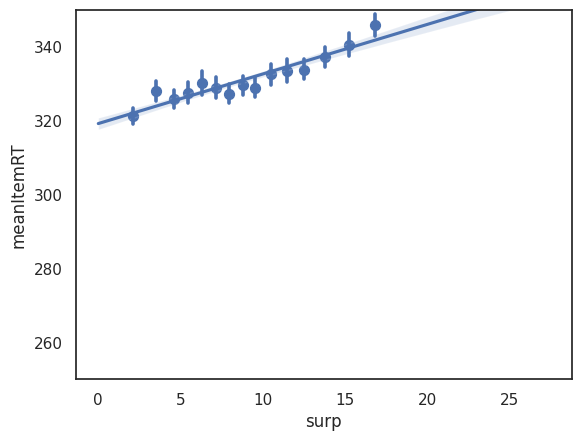

In [ ]:
g = sns.regplot(x="surp", y="meanItemRT", data=harmonized_stories, x_bins=15)
g.set_ylim([250, 350])

As expected, the results are similar to the original data set, however there are some interesting distinctions. First of all, the reading times distribution in this dataset is different than the original datase. The reading times here are generally higher and this can be seen both by the bias of the linear regression model, which is 319 in this dataset compared to about 280 in the original dataset, and by the graph. Additionally, our linear model that takes into account only surprisal achieved better results on this dataset.   

In [ ]:
y = harmonized_stories.iloc[:-1]['spillover']
x = harmonized_stories.iloc[:-1]['surp']
x = sm.add_constant(x)

lin_model= sm.OLS(y, x).fit()

print(lin_model.summary())
print('MSE:', mse(lin_model.predict(x), y))

                            OLS Regression Results                            
Dep. Variable:              spillover   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     17.20
Date:                Sat, 03 Jun 2023   Prob (F-statistic):           3.40e-05
Time:                        16:52:46   Log-Likelihood:                -41027.
No. Observations:                8277   AIC:                         8.206e+04
Df Residuals:                    8275   BIC:                         8.207e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        328.3467      0.827    396.816      0.0

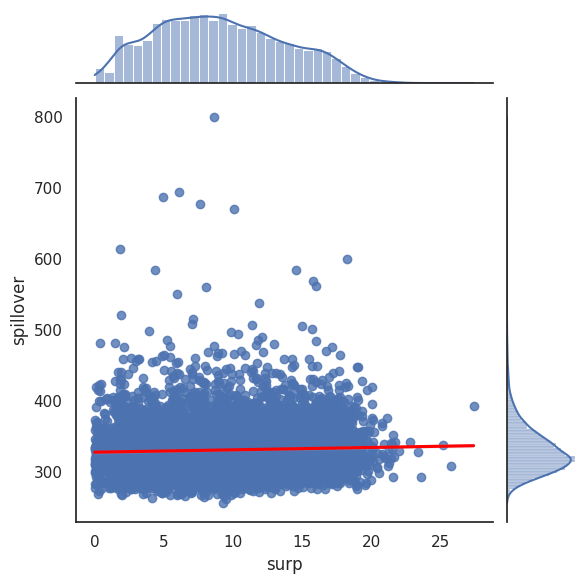

In [ ]:
g = sns.jointplot(x="surp", y="spillover", data=harmonized_stories.iloc[:-1], kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

(250.0, 350.0)

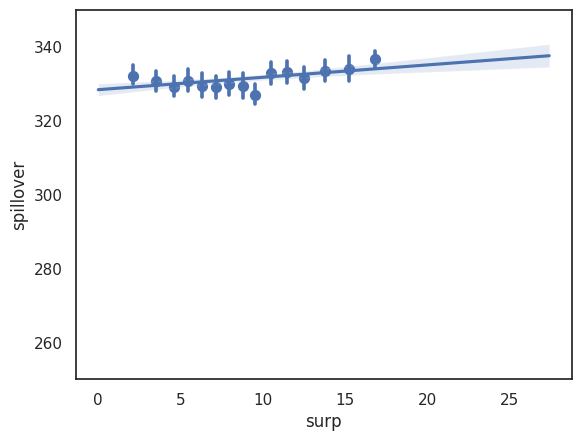

In [ ]:
g = sns.regplot(x="surp", y="spillover", data=harmonized_stories, x_bins=15)
g.set_ylim([250, 350])

Once again, the results are similar but this time surprisal receives a much lower coefficient, suggesting it doesn't affect the spillover as much

# Calculating Surprisal with Larger Models
In this section we will attempt to use larger models that have been trained on a much larger corpus in the hopes that these models will produce better surprisal estimates.

### GPT 2

In [ ]:
with open('/content/rnn/data/brown.txt', 'r', encoding='utf8') as file:
  text = file.read()

In [ ]:
"Credit: https://stackoverflow.com/questions/4576077/how-can-i-split-a-text-into-sentences"

import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"
multiple_dots = r'\.{2,}'

def split_into_sentences(text: str) -> list[str]:
    """
    Split the text into sentences.

    If the text contains substrings "<prd>" or "<stop>", they would lead
    to incorrect splitting because they are used as markers for splitting.

    :param text: text to be split into sentences
    :type text: str

    :return: list of sentences
    :rtype: list[str]
    """
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(multiple_dots, lambda match: "<prd>" * len(match.group(0)) + "<stop>", text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = [s.strip() for s in sentences]
    if sentences and not sentences[-1]: sentences = sentences[:-1]
    return sentences

In [ ]:
sents = split_into_sentences(text)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
inputs = [tokenizer(sent, return_tensors='pt') for sent in sents]

In [ ]:
for i in range(len(inputs)):
  torch.save(model(**inputs[i]), f'/content/gdrive/MyDrive/096222_project_surprisals_and_rts/gpt_outputs/output_{i}')

In [ ]:
outputs = [torch.load('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/gpt_outputs/' + output) for output in os.listdir('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/gpt_outputs/')]

In [ ]:
surprisal_dic = {'token': [], 'surprisal': []}

In [ ]:
print(sents[0].split(' '))

['In', "Ireland's", 'County', 'Limerick,', 'near', 'the', 'River', 'Shannon,', 'there', 'is', 'a', 'quiet', 'little', 'suburb', 'by', 'the', 'name', 'of', 'Garryowen,', 'which', 'means', '"Garden', 'of', 'Owen".']


In [ ]:
for input, output, sent in zip(inputs, outputs, sents):
  i = 0
  for word in sent.split(' '):
    token = ''
    prob = 1
    while token != word:
      token += tokenizer.decode(input['input_ids'][0, i]).strip()
      prob *= softmax(output.logits[0, i, :].detach().numpy())[i]
      i += 1
    surprisal_dic['token'].append(token)
    surprisal_dic['surprisal'].append(-np.log2(prob))

In [ ]:
surprisal_df = pd.DataFrame(surprisal_dic)

In [ ]:
sprt = pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code').reset_index(drop=True)

In [ ]:
def calc_mean_time(rt):
  rt = rt[(rt['time'] > 80) & (rt['time'] < 1500)]
  rt = rt[rt['time'] < (rt.groupby('subject')['time'].transform('mean') + 4*rt.groupby('subject')['time'].transform('std'))]
  rt['mean_time'] = rt.groupby('code')['time'].transform('mean')
  rt = rt.groupby('code').first().reset_index()[['word', 'mean_time']]
  return rt

def harmonize(surp, rt, problematic_rows=pd.Index([2188, 4485, 4505, 7143])):
  rt = calc_mean_time(rt)
  surp.loc[(surp['token'].str.contains('--')) | (surp.index.isin(problematic_rows)), 'surprisal'] = surp['surprisal'] + surp.shift(1)['surprisal']
  surp.loc[(surp['token'].str.contains('--'))  | (surp.index.isin(problematic_rows)), 'token'] = surp.shift(1)['token'] + ' ' + surp['token']
  surp = surp.drop(surp[surp['token'].str.contains('--')].index - 1).drop(problematic_rows - 1).reset_index()
  return surp.merge(rt, left_index=True, right_index=True)

In [ ]:
harmonized_gpt = harmonize(surprisal_df, sprt)

In [ ]:
harmonized_gpt.to_csv('/content/gdrive/MyDrive/096222_project_surprisals_and_rts/harmonized_gpt.csv')

In [ ]:
harmonized_gpt = pd.read_csv(f'{GDRIVE_DIR}/harmonized_gpt.csv')
harmonized_gpt = harmonized_gpt[harmonized_gpt['surprisal'] <= 100].reset_index(drop=True)
harmonized_gpt['len'] = harmonized_gpt['token'].str.len()
harmonized_gpt['freq'] = harmonized_gpt['token'].map(log_freq)
harmonized_gpt['spillover'] = harmonized_gpt['mean_time'].iloc[1:].reset_index(drop=True)

In [ ]:
y = harmonized_gpt['mean_time']
x = harmonized_gpt['surprisal']
x = sm.add_constant(x)

lin_model= sm.OLS(y, x).fit()

print(lin_model.summary())
print('MSE:', mse(lin_model.predict(x), y))

                            OLS Regression Results                            
Dep. Variable:              mean_time   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     277.1
Date:                Sun, 02 Jul 2023   Prob (F-statistic):           4.40e-61
Time:                        15:53:42   Log-Likelihood:                -37051.
No. Observations:                7179   AIC:                         7.411e+04
Df Residuals:                    7177   BIC:                         7.412e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        287.7638      1.137    253.180      0.0

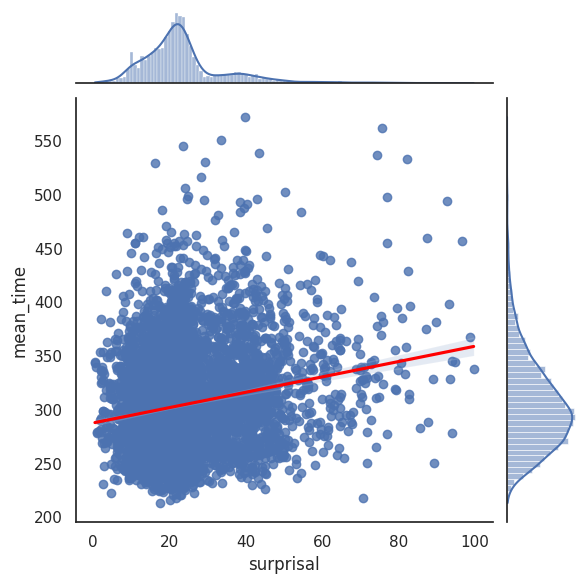

In [ ]:
g = sns.jointplot(x="surprisal", y="mean_time", data=harmonized_gpt, kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

In [ ]:
pd.read_csv(f'{GDRIVE_DIR}/harmonized_gpt.csv').sort_values('surprisal', ascending=False).head(10)

,Unnamed: 0,index,token,surprisal,word,mean_time
2231,2231,2247,mumbo-jumbo.,188.635483,mumbo-jumbo.,475.911000
4920,4920,4955,five-days-a-week,127.523387,five-days-a-week,462.855000
119,119,119,"anachronism,",112.012658,"anachronism,",251.314286
5592,5592,5631,Archipelago.,107.253647,Archipelago.,432.005714
4403,4403,4435,rights-of-way:,106.096830,rights-of-way:,369.198571
3903,3903,3930,smolderingly.,105.257675,smolderingly.,392.555000
4540,4540,4574,hastily-summoned,105.209548,hastily-summoned,351.761429
5535,5535,5574,black-and-orange,103.781018,black-and-orange,413.606250
4919,4919,4954,"nine-to-five,",102.972390,"nine-to-five,",479.546923
5444,5444,5483,profusely.,99.644046,profusely.,338.158000


(0.0, 50.0)

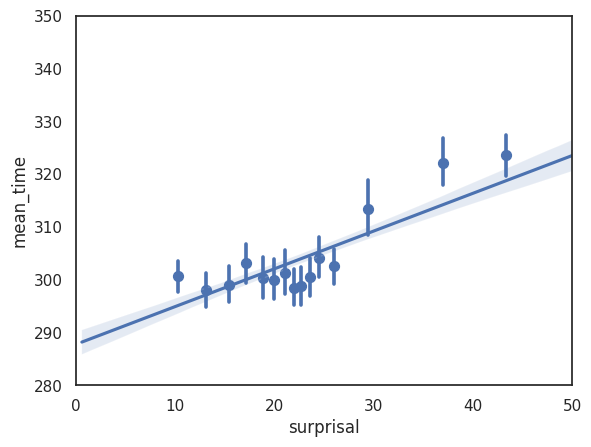

In [ ]:
g = sns.regplot(x="surprisal", y="mean_time", data=harmonized_gpt, x_bins=15)
g.set_ylim([280, 350])
g.set_xlim([0, 50])

In [ ]:
y = harmonized_gpt['mean_time']
x = harmonized_gpt[['surprisal', 'len', 'freq']]
x = sm.add_constant(x)

lin_model= sm.OLS(y, x).fit()

print(lin_model.summary())
print('MSE:', mse(lin_model.predict(x), y))

                            OLS Regression Results                            
Dep. Variable:              mean_time   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     262.2
Date:                Sun, 02 Jul 2023   Prob (F-statistic):          1.71e-161
Time:                        15:55:58   Log-Likelihood:                -36813.
No. Observations:                7179   AIC:                         7.363e+04
Df Residuals:                    7175   BIC:                         7.366e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        277.8019      2.288    121.439      0.0

                 Generalized Linear Model Regression Results                  
Dep. Variable:              mean_time   No. Observations:                 7179
Model:                         GLMGam   Df Residuals:                     7169
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          1653.7
Method:                         PIRLS   Log-Likelihood:                -36783.
Date:                Sun, 02 Jul 2023   Deviance:                   1.1855e+07
Time:                        15:58:45   Pearson chi2:                 1.19e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1122
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          292.0849      4.062     71.913   

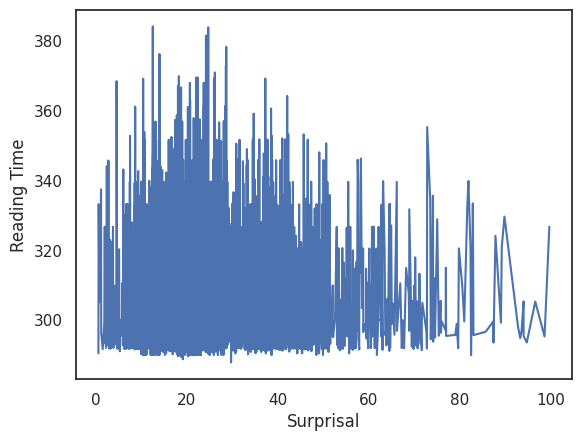

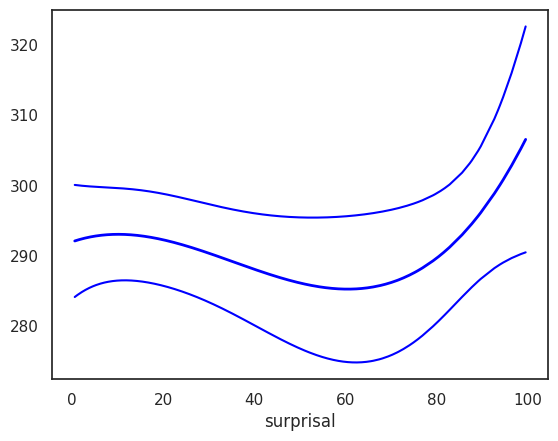

In [ ]:
plot_gam_model(harmonized_gpt[['surprisal', 'len', 'freq']], harmonized_gpt['mean_time'], 'Surprisal')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              spillover   No. Observations:                 7178
Model:                         GLMGam   Df Residuals:                     7168
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          1645.8
Method:                         PIRLS   Log-Likelihood:                -36760.
Date:                Wed, 05 Jul 2023   Deviance:                   1.1797e+07
Time:                        13:09:02   Pearson chi2:                 1.18e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1169
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          312.3865      4.052     77.096   

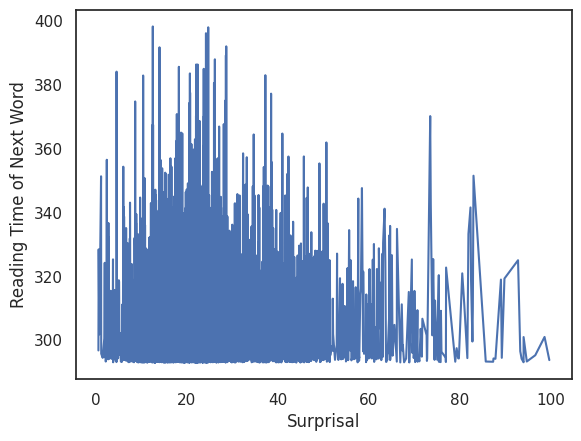

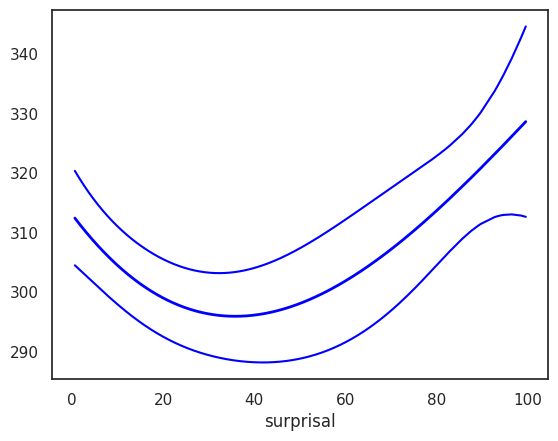

In [ ]:
plot_gam_model(harmonized_gpt.iloc[:-1][['surprisal', 'len', 'freq']], harmonized_gpt.iloc[:-1]['spillover'], 'Surprisal', 'Reading Time of Next Word')

In [ ]:
harmonized_gpt['mean_time']

0       350.145625
1       335.850588
2       296.042941
3       419.968000
4       348.327500
           ...    
7183    284.470833
7184    282.622083
7185    279.445417
7186    299.705000
7187    381.612083
Name: mean_time, Length: 7179, dtype: float64

In [ ]:
print('gpt surprisal correlation with reading time:', harmonized_gpt['surprisal'].corr(harmonized_gpt['mean_time']))

gpt surprisal correlation with reading time: 0.19281401496100384


# Unlexicalized Surprisal

So far we have attempt to discern the relationship between the surprisal value of words to the reading time with mixed results. Now, we want to look at the relationship between the unlexicalized surprisal and the reading time. Instead of looking at the probability of a specific word, we will look at the probability of its part of speech, conditioned on the parts of speech of the previous words. To tag our text we will use the part of speech tagger provided in the flair python package. To calculate the surprisal we will use an rnn.

### Part 1: Tagging our dataset

In [ ]:
def tag_file(tagger, splitter, text_file, pos_file):
  with open(text_file, 'r', encoding='utf8') as file, open(pos_file, 'w', encoding='utf8') as new_file:
    data = file.read()
    sentences = splitter.split(data)
    tagger.predict(sentences)
    new_file.write(' '.join([label.value for sentence in sentences for label in sentence.labels]))
  return sentences

In [ ]:
tagger = SequenceTagger.load("flair/pos-english-fast")
splitter = SegtokSentenceSplitter()

NameError: ignored

In [ ]:
with open(f'{GDRIVE_DIR}/corpus_data/ptb_tok_train.txt', 'r', encoding='utf8') as training, open(f'{GDRIVE_DIR}/corpus_data/ptb_tok_dev.txt', 'r', encoding='utf8') as validation:
  training_data = training.read()
  validation_data = validation.read()
  training_sentences = splitter.split(training_data)
  validation_sentences = splitter.split(validation_data)
  tagger.predict(training_sentences)
  tagger.predict(validation_sentences)


In [ ]:
with open(f'{GDRIVE_DIR}/corpus_data/ptb_tok_train_pos.txt', 'w', encoding='utf8') as training, open(f'{GDRIVE_DIR}/corpus_data/ptb_tok_dev_pos.txt', 'w', encoding='utf8') as validation:
  training.write(' '.join([label.value for sentence in training_sentences for label in sentence.labels]))
  validation.write(' '.join([label.value for sentence in validation_sentences for label in sentence.labels]))

### Part 2: Training RNN Model



In [ ]:
vocab = tagger.label_dictionary.get_items()
with open(f'{GDRIVE_DIR}/ptb_vocab_pos.txt', 'w', encoding='utf8') as vocab_file:
  vocab[0] = '<eos>'
  vocab_file.write('\n'.join(vocab))

In [ ]:
!cd rnn && python main.py --cuda --model_file "$GDRIVE_DIR/ptb_model_pos.pt" \
    --epochs 40 \
    --vocab_file "$GDRIVE_DIR/ptb_vocab_pos.txt" \
    --tied --data_dir "$GDRIVE_DIR/corpus_data" --trainfname ptb_tok_train_pos.txt --validfname ptb_tok_dev_pos.txt

Libraries loaded
| epoch   1 |   200/ 1480 batches | lr 20.00 | ms/batch  7.37 | loss  4.03 | ppl    56.15
| epoch   1 |   400/ 1480 batches | lr 20.00 | ms/batch  4.20 | loss  3.79 | ppl    44.19
| epoch   1 |   600/ 1480 batches | lr 20.00 | ms/batch  4.27 | loss  3.39 | ppl    29.71
| epoch   1 |   800/ 1480 batches | lr 20.00 | ms/batch  4.50 | loss  3.08 | ppl    21.68
| epoch   1 |  1000/ 1480 batches | lr 20.00 | ms/batch  4.42 | loss  2.98 | ppl    19.62
| epoch   1 |  1200/ 1480 batches | lr 20.00 | ms/batch  4.31 | loss  2.93 | ppl    18.72
| epoch   1 |  1400/ 1480 batches | lr 20.00 | ms/batch  4.38 | loss  3.00 | ppl    20.12
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  7.10s | lr: 20.00000000 | valid ppl    21.75
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1480 batches | lr 20.00 | ms/batch  4.42 | loss  2.94 | ppl    19.00
| epoch   

### Part 3: Calculating Surprisal & Comparing with Reading Time

In [ ]:
test_sentences = tag_file(tagger, splitter, '/content/rnn/data/brown.txt', f'{GDRIVE_DIR}/brown_pos.txt')

In [ ]:
checkpoint_to_use =  f"{GDRIVE_DIR}/ptb_model_pos.pt"

In [ ]:
!cd rnn && python main.py --cuda --model_file "$checkpoint_to_use" \
    --vocab_file "$GDRIVE_DIR/ptb_vocab_pos.txt" --data_dir '/content/gdrive/MyDrive/096222_project_surprisals_and_rts' \
    --testfname 'brown_pos.txt' --test --words --nopp > "$GDRIVE_DIR/rnn_surprisals_pos.tsv"

Libraries loaded
Using beamsize: 53


In [ ]:
pos_surp = pd.read_csv(f'{GDRIVE_DIR}/rnn_surprisals_pos.tsv', sep=' ')
pos_surp

,word,sentid,sentpos,wlen,surp,entropy,entred
0,IN,0,0,2,2.942962,4.274142,0.000000
1,NNP,0,1,3,2.746130,3.513457,0.760685
2,POS,0,2,3,4.795339,3.909455,0.000000
3,NNP,0,3,3,5.478043,1.185891,2.723564
4,NNP,0,4,3,1.428215,3.164410,0.000000
...,...,...,...,...,...,...,...
8421,DT,398,17,2,1.611761,3.423770,0.318359
8422,NN,398,18,2,1.101359,2.650747,0.773023
8423,CC,398,19,2,4.783673,3.484024,0.000000
8424,NN,398,20,2,2.655099,4.224254,0.000000


We notice that the surprisal values are smaller. Since there are less possible tokens, our model is more confident in his choices and each token has a higher base probability, therefore this result is expected.

In [ ]:
pos_surp['original_word'] = [token.text for sentence in test_sentences for token in sentence.tokens]

In [ ]:
harmonized = {'mean_time': [], 'token': [], 'surprisal': []}
sprt = calc_mean_time(pd.read_csv('https://gist.githubusercontent.com/omershubi/01b55eab89b81dc882055e0d27d61016/raw/046dbb7f0586b5dc1a368ee882f2cb923caad3df/brown-spr-data-for-pset.csv', index_col=0).sort_values(by='code').reset_index(drop=True))
j = 0
for i, row in sprt.iterrows():
  word = row['word']
  harmonized['mean_time'].append(row['mean_time'])
  token = ''
  surp = 1
  while token != word:
    token += ' ' if word[len(token)] == ' ' else ''
    token += pos_surp.iloc[j]['original_word']
    surp += pos_surp.iloc[j]['surp']
    j += 1
  harmonized['token'].append(token)
  harmonized['surprisal'].append(surp)

In [ ]:
harmonized_pos = pd.DataFrame(harmonized)
harmonized_pos.to_csv(f'{GDRIVE_DIR}/harmonized_pos.csv')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'harmonized' is not defined

In [ ]:
harmonized_pos = pd.read_csv(f'{GDRIVE_DIR}/harmonized_pos.csv')

In [ ]:
harmonized_pos

,Unnamed: 0,mean_time,token,surprisal
0,0,350.145625,In,3.942962
1,1,335.850588,Ireland's,8.541469
2,2,296.042941,County,6.478043
3,3,419.968000,"Limerick,",5.077165
4,4,348.327500,near,3.896885
...,...,...,...,...
7183,7183,284.470833,as,2.721151
7184,7184,282.622083,a,2.611761
7185,7185,279.445417,leader,2.101359
7186,7186,299.705000,and,5.783673


In [ ]:
harmonized_pos.sort_values('surprisal', ascending=False).head(10)

,Unnamed: 0,mean_time,token,surprisal
7088,7088,339.611667,"(Later,",43.918898
4994,4994,280.869375,had,27.530128
6384,6384,367.281875,1960).,26.603993
6112,6112,298.324000,"""Please,""",23.870048
698,698,282.188947,others'.,23.612109
2420,2420,302.889545,"again,""",23.007953
1330,1330,295.932857,"me,""",22.703456
4511,4511,361.656875,"land?""",22.480600
3558,3558,269.275556,where.,21.405567
2851,2851,358.140000,disastrous),21.163260


In [ ]:
harmonized_pos = harmonized_pos[harmonized_pos['surprisal'] <= 20]

In [ ]:
y = harmonized_pos['mean_time']
x = harmonized_pos['surprisal']
x = sm.add_constant(x)

lin_model= sm.OLS(y, x).fit()

print(lin_model.summary())
print('MSE:', mse(lin_model.predict(x), y))

                            OLS Regression Results                            
Dep. Variable:              mean_time   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     138.1
Date:                Sun, 02 Jul 2023   Prob (F-statistic):           1.36e-31
Time:                        13:53:49   Log-Likelihood:                -37119.
No. Observations:                7173   AIC:                         7.424e+04
Df Residuals:                    7171   BIC:                         7.426e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        293.4052      1.099    267.017      0.0

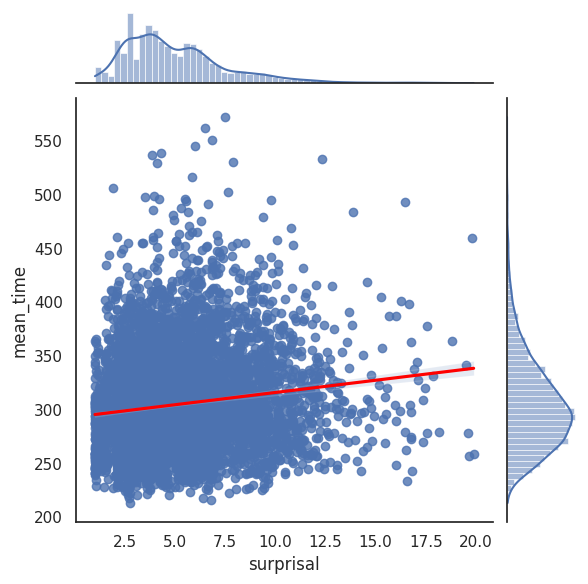

In [ ]:
g = sns.jointplot(x="surprisal", y="mean_time", data=harmonized_pos[harmonized_pos['surprisal'] < 20], kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

(0.0, 20.0)

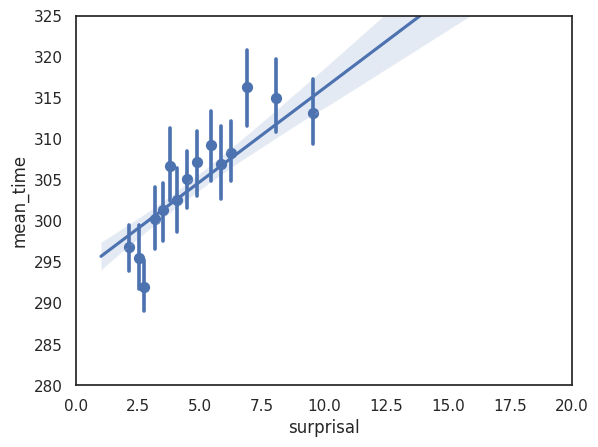

In [ ]:
g = sns.regplot(x="surprisal", y="mean_time", data=harmonized_pos, x_bins=15)
g.set_ylim([280, 325])
g.set_xlim([0, 20])

In [ ]:
harmonized_pos['len'] = harmonized_pos['token'].str.len()
harmonized_pos['freq'] = harmonized_pos['token'].map(log_freq)
harmonized_pos['spillover'] = harmonized_pos['mean_time'].iloc[1:].reset_index(drop=True)

In [ ]:
y = harmonized_pos['mean_time']
x = harmonized_pos[['surprisal', 'len', 'freq']]
x = sm.add_constant(x)

lin_model= sm.OLS(y, x).fit()

print(lin_model.summary())
print('MSE:', mse(lin_model.predict(x), y))

                            OLS Regression Results                            
Dep. Variable:              mean_time   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     275.8
Date:                Sun, 02 Jul 2023   Prob (F-statistic):          2.10e-169
Time:                        14:06:54   Log-Likelihood:                -36796.
No. Observations:                7173   AIC:                         7.360e+04
Df Residuals:                    7169   BIC:                         7.363e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        274.5046      2.429    113.018      0.0

In [ ]:
g = sns.jointplot(x="surprisal", y="mean_time", data=harmonized_pos[harmonized_pos['surprisal'] < 20], kind='reg')
# We're going to make the regression line red so it's easier to see
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              mean_time   No. Observations:                 7173
Model:                         GLMGam   Df Residuals:                     7163
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          1647.9
Method:                         PIRLS   Log-Likelihood:                -36739.
Date:                Sun, 02 Jul 2023   Deviance:                   1.1804e+07
Time:                        14:41:04   Pearson chi2:                 1.18e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1246
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          279.3906      3.609     77.419   

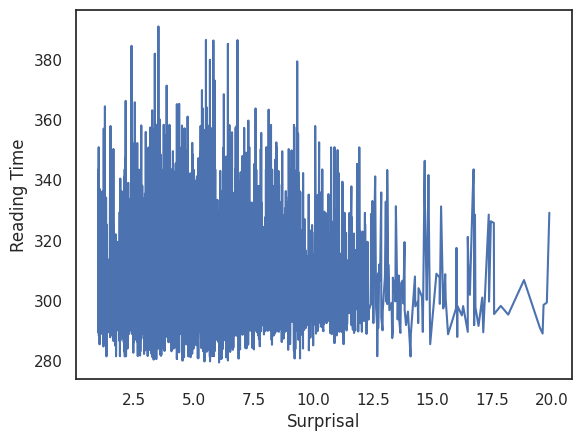

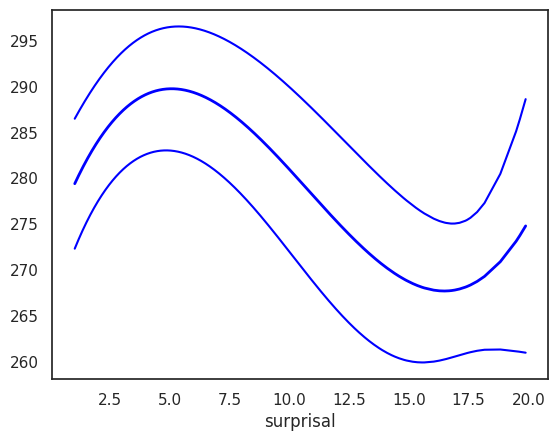

In [ ]:
plot_gam_model(harmonized_pos[['surprisal', 'freq', 'len']], harmonized_pos['mean_time'], 'Surprisal')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              spillover   No. Observations:                 7187
Model:                         GLMGam   Df Residuals:                     7177
Model Family:                Gaussian   Df Model:                         9.00
Link Function:               identity   Scale:                          1653.4
Method:                         PIRLS   Log-Likelihood:                -36823.
Date:                Wed, 05 Jul 2023   Deviance:                   1.1866e+07
Time:                        18:39:50   Pearson chi2:                 1.19e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1207
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          301.4968      3.395     88.803   

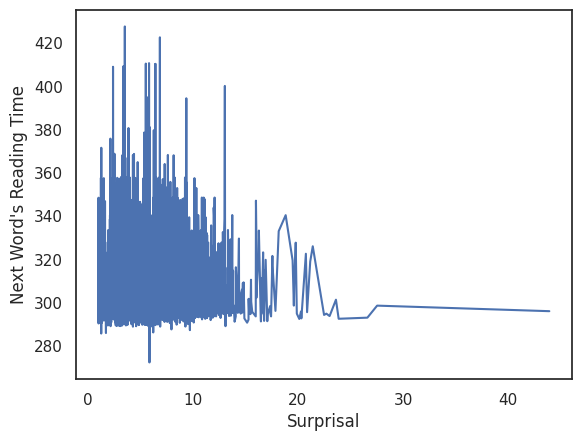

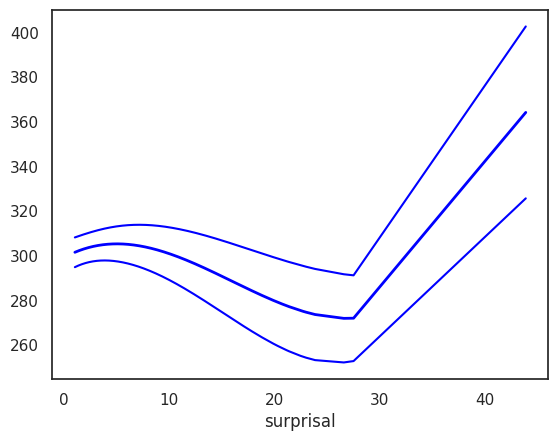

In [ ]:
plot_gam_model(harmonized_pos.iloc[:-1][['surprisal', 'freq', 'len']], harmonized_pos.iloc[:-1]['spillover'], 'Surprisal', "Next Word's Reading Time")

In [ ]:
print('rnn surprisal correlation with reading time:', harmonized_pos['surprisal'].corr(harmonized_pos['mean_time']))

rnn surprisal correlation with reading time: 0.13745010456721077
